<a href="https://colab.research.google.com/github/danielselmin/scientific_literature/blob/main/miniproject2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
pip install scanpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 13.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.5 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=429a5590f93a64ef046a6e246b59bc8bb0ab2818fcb870fc06f8d2d830d3a867
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=1d9fe3518a9566955d76a23c08ba2328525918064b9d72006ae1c2f919db03ad
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9

In [4]:
from google.colab import files
uploaded = files.upload()

Saving GSM3399102_rawCounts.csv.gz to GSM3399102_rawCounts.csv.gz


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# use anaconda/miniconda to ensure packages are right version, otherwise plotting might give error for color

## Load data

In [2]:
adata = sc.read_csv("GSM3399102_rawCounts.csv.gz").T

## 1. Quality control

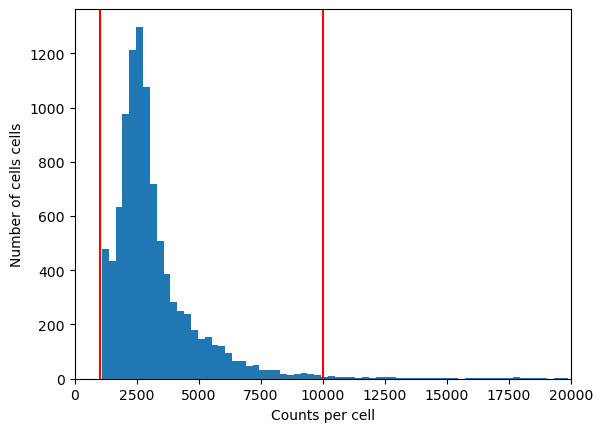

In [3]:
adata.obs['n_counts'] = adata.X.sum(axis=1)
plt.hist(adata.obs['n_counts'], bins=100)
plt.xlabel("Counts per cell") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of cells cells") # what are you plotting on the x-axis? Label it!
plt.axvline(1000, c="r") # specify the lower cutoff value for total UMIs
plt.axvline(10000, c="r") # specify the upper cutoff value for total UMIs
plt.xlim(0, 20000)
plt.show()

From the plot, the data is already filtered for UMI counts per cell

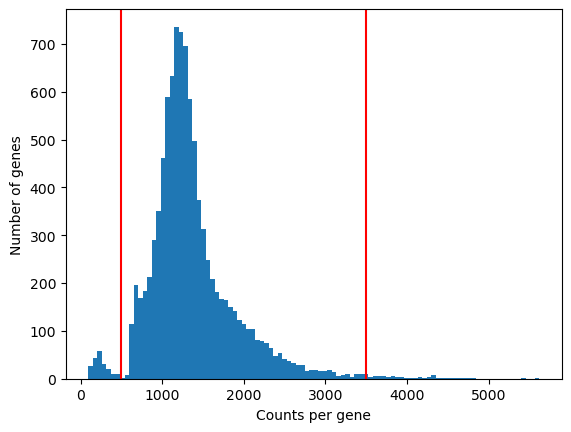

In [4]:
# look at gene counts per geneb
expressed_genes = np.sum(adata.X > 0, 1)
adata.obs['n_genes'] = expressed_genes

plt.hist(adata.obs['n_genes'], bins=100)
plt.axvline(500, c="r") # specify the lower cutoff for number of detected genes
plt.axvline(3500, c="r") # specify the upper cutoff for number of detected genes
plt.xlabel("Counts per gene") # what are you plotting on the x-axis? Label it!
plt.ylabel("Number of genes") # what are you plotting on the x-axis? Label it!
plt.show()

c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\jurri\miniconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is

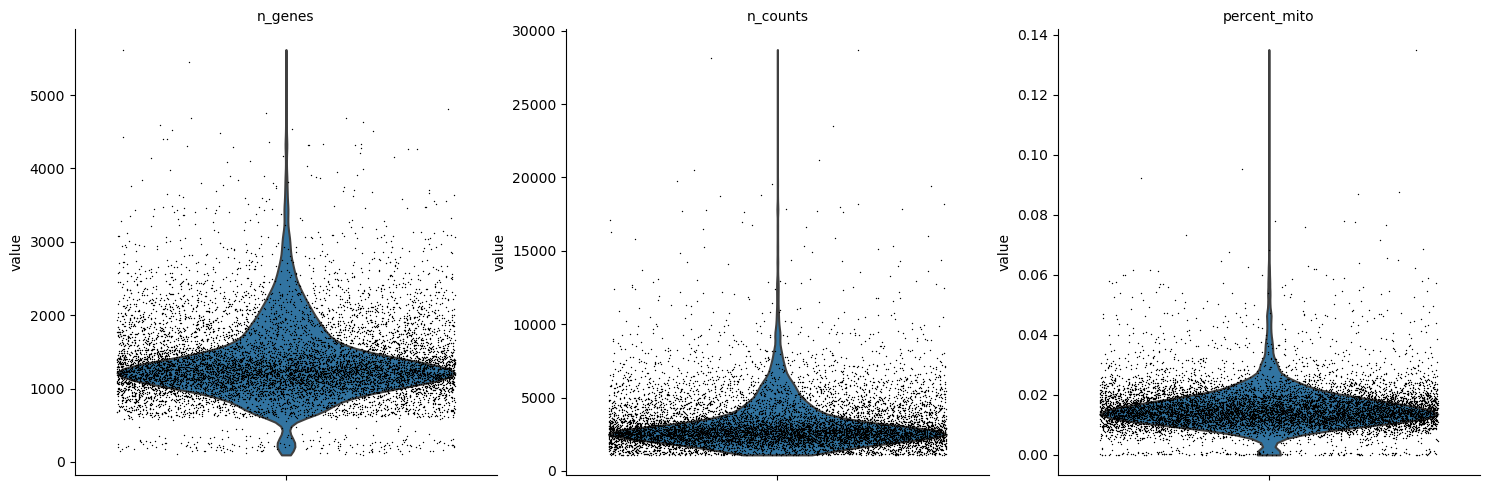

In [5]:
# finally check percentage of mitochondrial genes
mito_genes = adata.var_names.str.startswith('mt-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True)

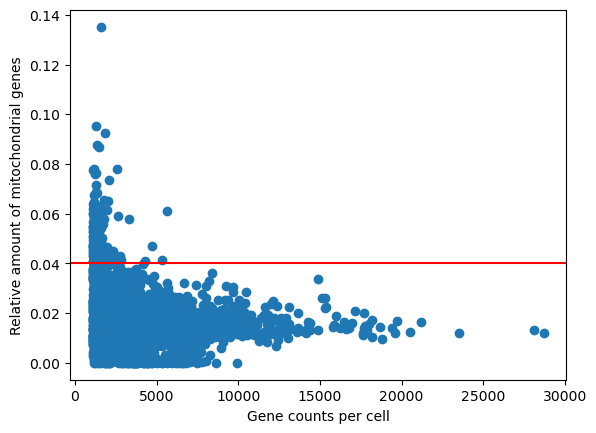

In [6]:
plt.scatter(adata.obs["n_counts"], adata.obs["percent_mito"])
plt.xlabel("Gene counts per cell") # specify the lower cutoff for number of detected genes
plt.ylabel("Relative amount of mitochondrial genes") # specify the lower cutoff for number of detected genes
plt.axhline(0.04, c='red') # specify a threshold (decimal from 0 to 1) for percentage mitochondrial reads
plt.show()

## 1.1 filter the data
Based on the above plots, we suggest to cut-off data for higher than 0.04 mitochondrial percentage,and to keep data within 500 and 3500 counts per gene and 1000to 10,000 gene counts per cell.
To improve, set boundaries with some algorithm based on the distributions?

In [7]:
sc.pp.filter_cells(adata, min_counts=1000) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_counts=10000) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, min_genes=500) # apply threshold from above to actually do the filtering
sc.pp.filter_cells(adata, max_genes=3500) # apply threshold from above to actually do the filtering
adata = adata[adata.obs['percent_mito'] < 0.04, :].copy() # apply threshold from above to actually do the filtering

In [8]:
# filter genes expressed in less than 1% of cells (why?)
sc.pp.filter_genes(adata, min_cells=adata.n_obs*0.01)

## 2. Normalization
Address variability caused by sc sequencing process

In [9]:
adata.raw = adata.copy()
adata_raw = adata.copy()

In [10]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

## 3. Feature selection

In [11]:
# Get cell states (S, G2m vs G1, G0)
S_genes_mouse = ['Mcm5', 'Pcna', 'Tyms', 'Fen1', 'Mcm2', 'Mcm4', 'Rrm1', 'Ung',
       'Gins2', 'Mcm6', 'Cdca7', 'Dtl', 'Prim1', 'Uhrf1', 'Cenpu',
       'Hells', 'Rfc2', 'Rpa2', 'Nasp', 'Rad51ap1', 'Gmnn', 'Wdr76',
       'Slbp', 'Ccne2', 'Ubr7', 'Pold3', 'Msh2', 'Atad2', 'Rad51', 'Rrm2',
       'Cdc45', 'Cdc6', 'Exo1', 'Tipin', 'Dscc1', 'Blm', 'Casp8ap2',
       'Usp1', 'Clspn', 'Pola1', 'Chaf1b', 'Brip1', 'E2f8']
G2M_genes_mouse = ['Hmgb2', 'Cdk1', 'Nusap1', 'Ube2c', 'Birc5', 'Tpx2', 'Top2a',
       'Ndc80', 'Cks2', 'Nuf2', 'Cks1b', 'Mki67', 'Tmpo', 'Cenpf',
       'Tacc3', 'Pimreg', 'Smc4', 'Ccnb2', 'Ckap2l', 'Ckap2', 'Aurkb',
       'Bub1', 'Kif11', 'Anp32e', 'Tubb4b', 'Gtse1', 'Kif20b', 'Hjurp',
       'Cdca3', 'Jpt1', 'Cdc20', 'Ttk', 'Cdc25c', 'Kif2c', 'Rangap1',
       'Ncapd2', 'Dlgap5', 'Cdca2', 'Cdca8', 'Ect2', 'Kif23', 'Hmmr',
       'Aurka', 'Psrc1', 'Anln', 'Lbr', 'Ckap5', 'Cenpe', 'Ctcf', 'Nek2',
       'G2e3', 'Gas2l3', 'Cbx5', 'Cenpa']

sc.tl.score_genes_cell_cycle(adata, s_genes=S_genes_mouse, g2m_genes=G2M_genes_mouse)

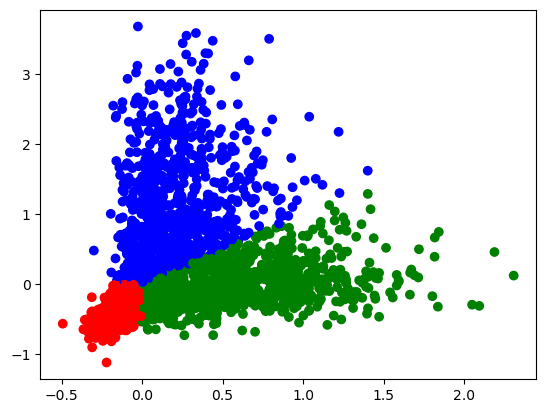

In [12]:
n2c = {"G1":"red", "S":"green", "G2M":"blue"} # use to assign each cell a color based on phase in the scatter plot
colors = []
for phase in adata.obs['phase']:
    colors.append(n2c[phase])

plt.scatter(adata.obs['S_score'], adata.obs['G2M_score'], c=colors)
plt.show()

In [13]:
adata.obs["phase"].value_counts()

phase
G1     6741
S      1670
G2M     955
Name: count, dtype: int64

Select 2000 highest variance components

In [14]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, min_disp=0.5, 
                            max_disp=np.inf, min_mean=0.0125, max_mean=3, span=0.3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\preprocessing\_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [15]:
adata = adata[:, adata.var["highly_variable"]].copy() # actually do the filtering

In [16]:
adata

AnnData object with n_obs × n_vars = 9366 × 2000
    obs: 'n_counts', 'n_genes', 'percent_mito', 'S_score', 'G2M_score', 'phase'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [17]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito', 'S_score', 'G2M_score']) # specify which feature from adata.obs you want to regress out, if any

## 4. Principal component analysis

In [18]:
sc.tl.pca(adata, svd_solver='arpack')

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


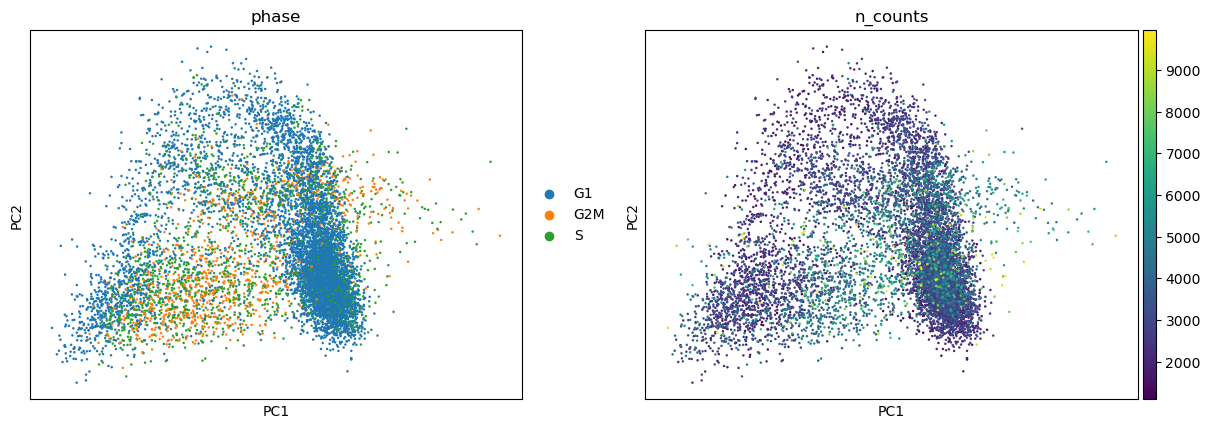

In [19]:
sc.pl.pca(adata, color=['phase','n_counts'])

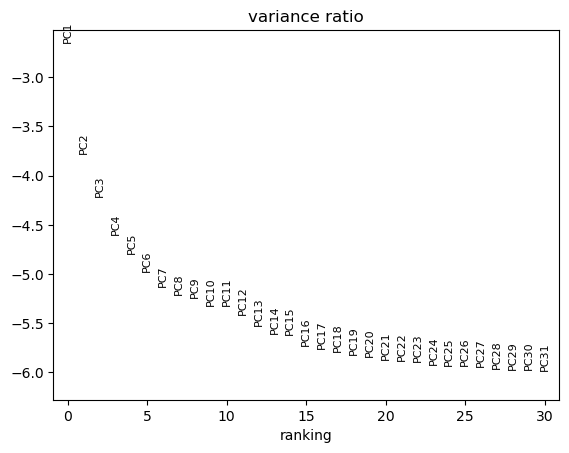

In [20]:
sc.pl.pca_variance_ratio(adata, log=True) # see contribution of each PC to variance

## 5. Dimensionality reduction 

In [21]:
sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30) # specify the number of neighbors and number of PCs you wish to use

c:\Users\jurri\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
sc.tl.tsne(adata, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\jurri\miniconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [23]:
sc.tl.umap(adata, alpha=0.3, min_dist=0.5, random_state=0)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


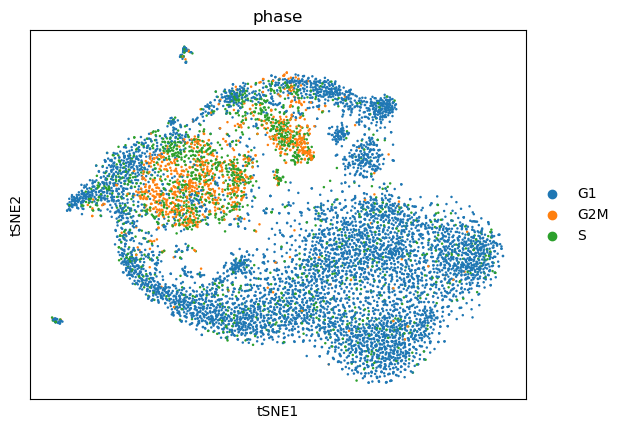

In [24]:
# visualize the tSNE colored by phase
sc.pl.tsne(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


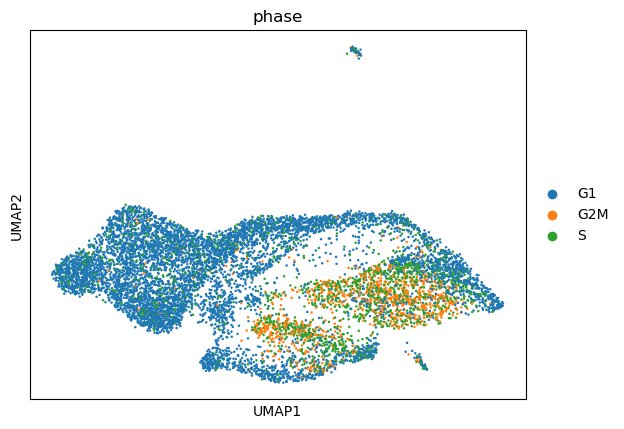

In [25]:
# visualize the UMAP colored by phase
sc.pl.umap(adata, color='phase', use_raw=False, wspace=0.3, ncols=3)

## 6. Clustering

In [62]:
resolution = 1
# sc.tl.louvain(adata, resolution=resolution)
sc.tl.leiden(adata, resolution=resolution)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


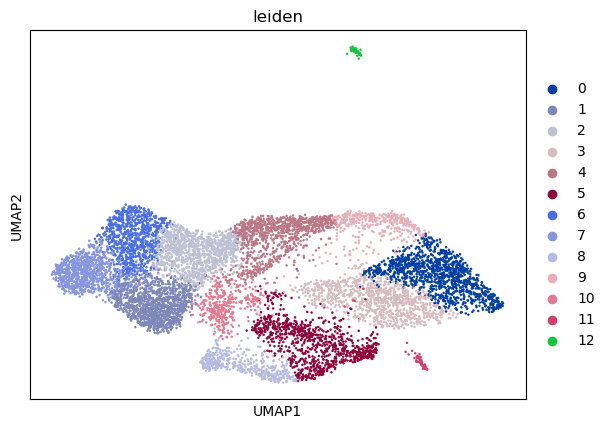

In [63]:
sc.pl.umap(adata, color=['leiden'], use_raw=False, wspace=0.3, ncols=2)

c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
c:\Users\jurri\miniconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


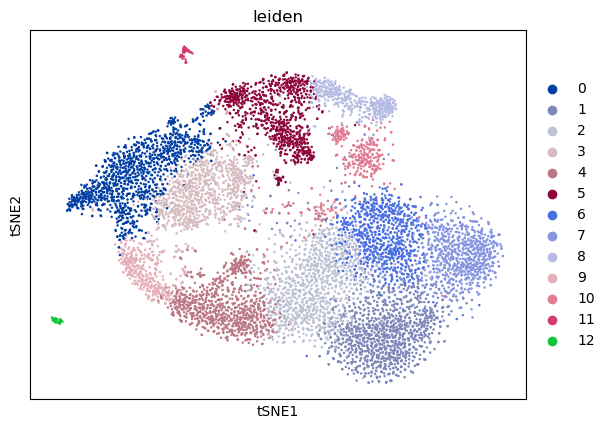

In [64]:
sc.pl.tsne(adata, use_raw=False, color='leiden', wspace=0.3, ncols=2) # color by louvain and leiden

## 7. Identifying marker genes and cell types
Before proceeding with marker gene analysis and cell type annotation, restore the raw version of the data, add the necessary annotations, and normalize the counts:

In [65]:
adata_raw_norm = adata_raw.copy()

# normalize the counts
sc.pp.normalize_total(adata_raw_norm)
# log transform the counts
sc.pp.log1p(adata_raw_norm)
# transfer over the metadata
adata_raw_norm.obsm["X_umap"] = adata.obsm["X_umap"]
adata_raw_norm.obs["leiden"] = [i for i in adata.obs["leiden"]]

In [66]:
sc.tl.rank_genes_groups(adata_raw_norm, 'leiden', use_raw=False, method="t-test")

In [59]:
marker_genes = pd.DataFrame(adata_raw_norm.uns["rank_genes_groups"]["names"])
marker_genes.head(5)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,Nnat,Tmsb10,Chmp2b,Tuba1a,Tmsb10,Fabp7,Fabp7,Ptn,Tubb3,Pcp4,...,Cdkn1c,Mdk,Fabp7,Fabp7,Nefl,Neurod6,Cd81,Ybx1,Cdkn1c,Hba-a1
1,Tmsb10,Nnat,Tuba1a,Tubb3,Nnat,Ptn,Ptn,Gap43,Igfbpl1,Gap43,...,Gadd45g,Tuba1b,Serpine2,Ptn,Gm2694,Igfbpl1,Pfn1,Tuba1b,Tubb3,Hbb-bs
2,Ftl1,Fgf3,Gap43,Nrgn,Podxl2,Id3,Vim,Pax6,Tuba1a,Ebf1,...,Hes6,Hmgb2,Vim,Pea15a,Stmn2,Tubb3,Serpinh1,Rrm2,Igfbpl1,Hbb-bt
3,Tuba1a,Lhx1os,Ebf1,Nhlh2,Tuba1a,Ran,Hes5,Neurod1,Nhlh2,Tmsb10,...,Tmsb4x,Ran,Pea15a,Serpine2,Tmsb10,Neurod2,Myl12a,Pcna,Sox4,Csmd2
4,Olfm1,Mllt11,Tubb3,Pid1,Islr2,Vim,Pea15a,Stmn2,Stmn2,Tuba1a,...,Pvalb,Id3,Gpm6b,Hmgb2,Tubb3,Lamp5,Igfbp7,Ran,Sox11,Fth1


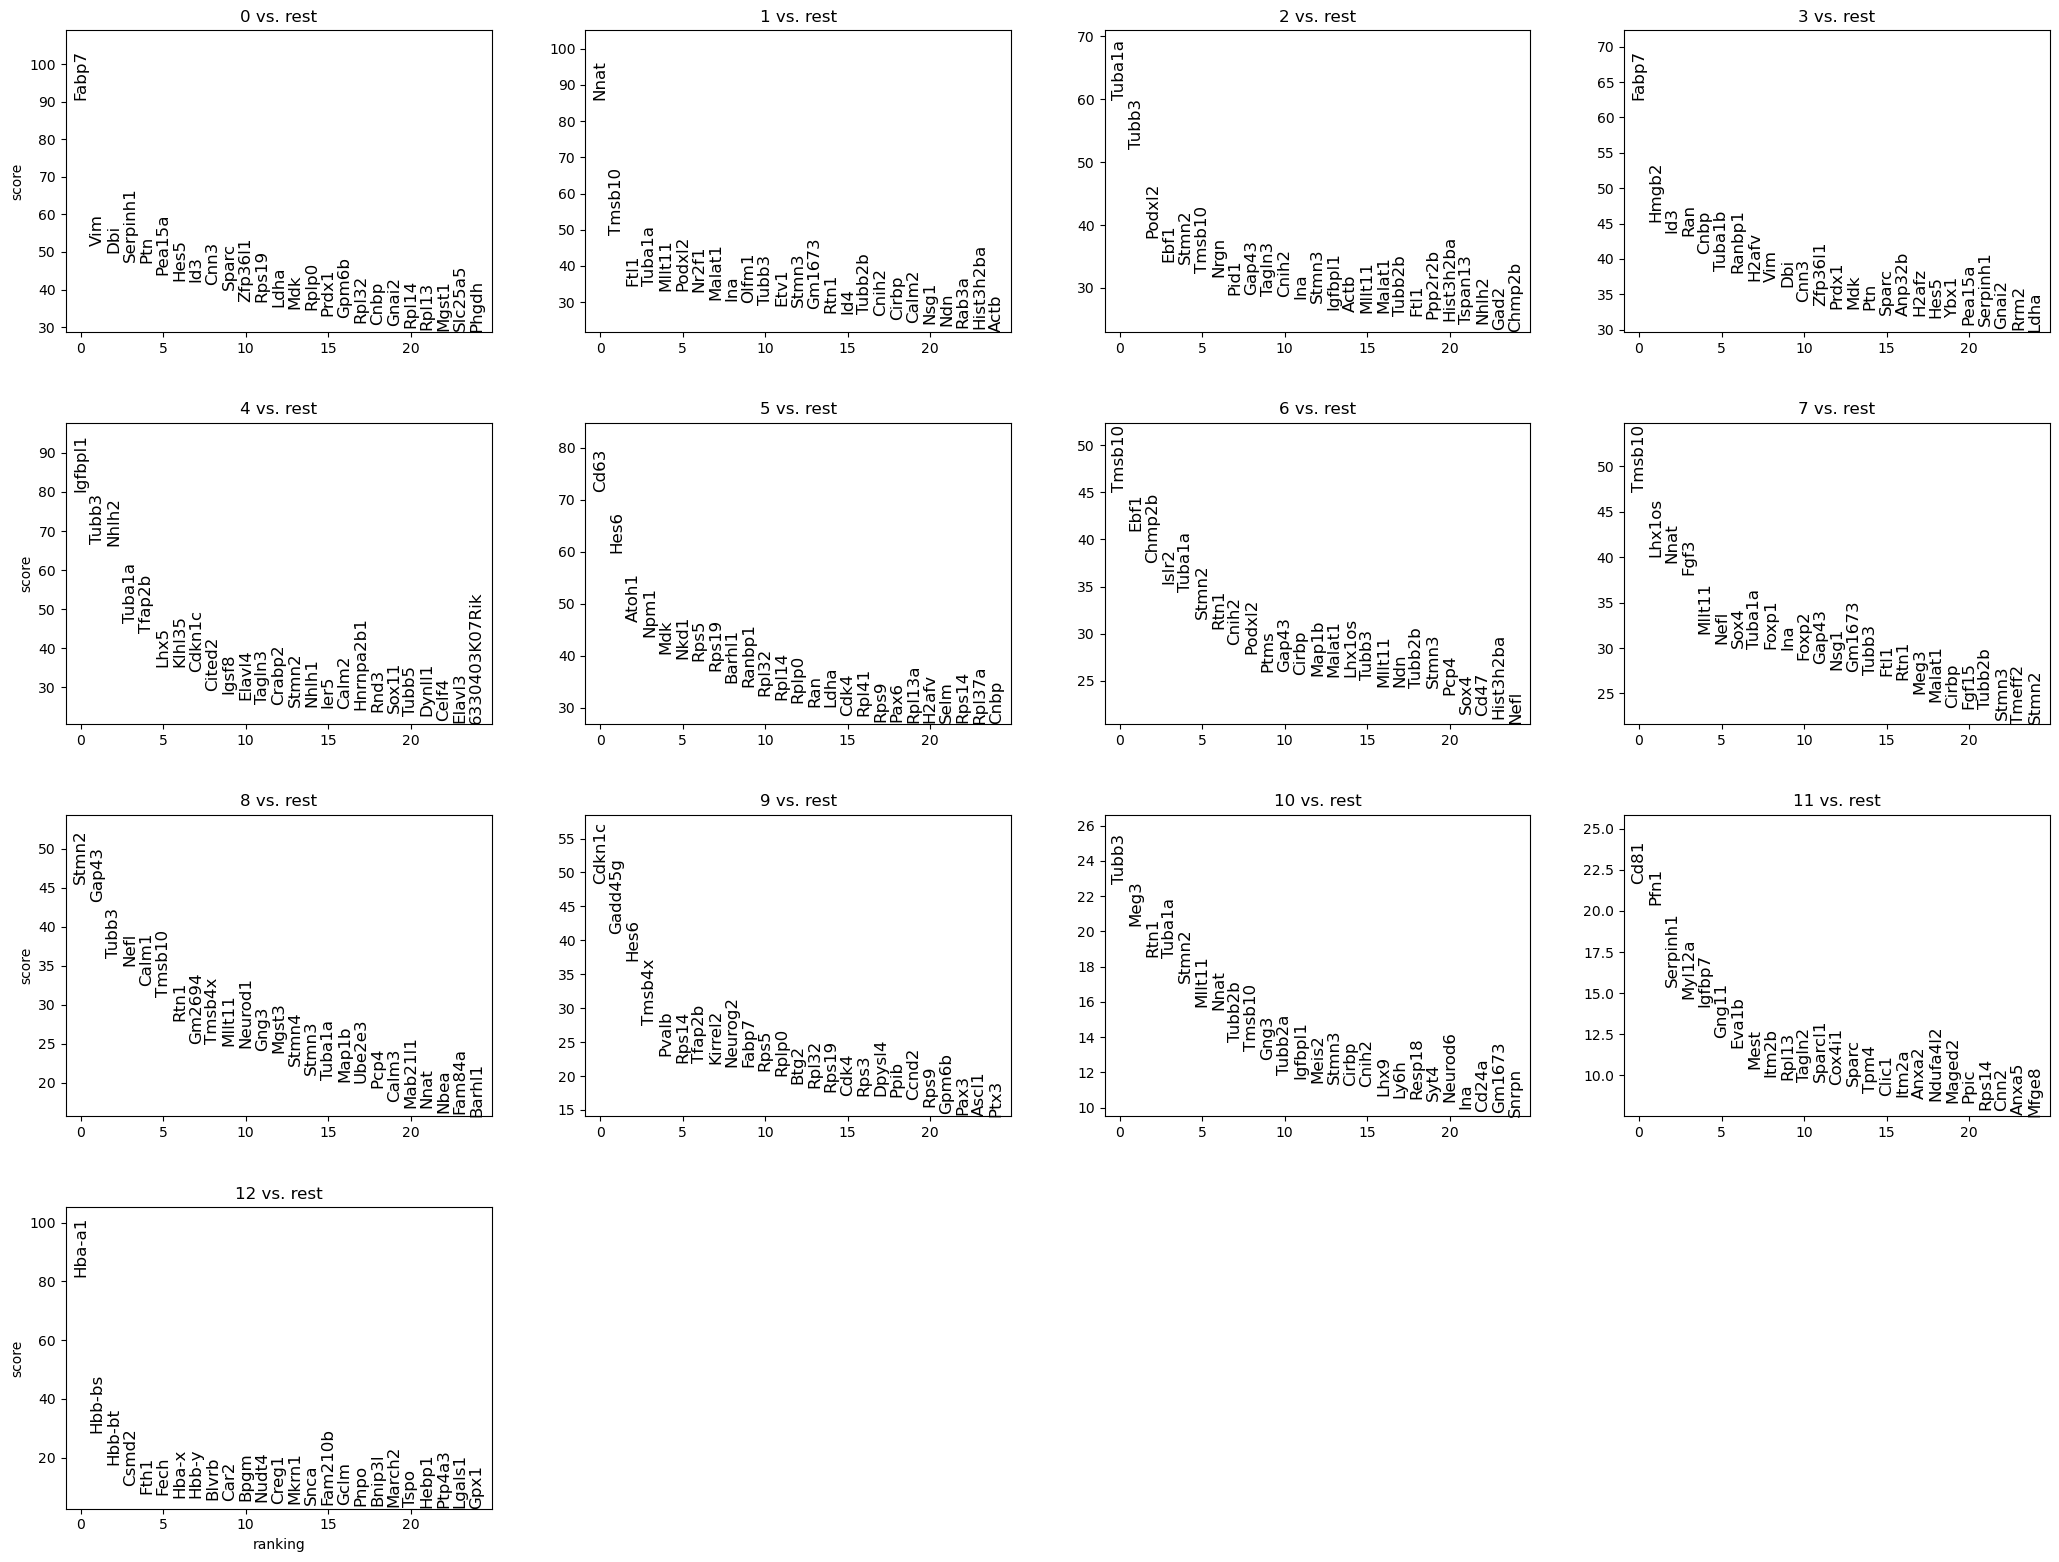

In [68]:
sc.pl.rank_genes_groups(adata_raw_norm, n_genes=25, sharey=False, fontsize=12)


In [ ]:
# Link highly expressed genes to cell types

"Fabp7", "Vim"
"Oligodendrocyte Progenitor Cells": ["Nnat"]
"Neural Crest Stem cell": ["Tubu1a", "Tubb3"]
"Neural Progenitor cell": ["Fabp7", "Hmgb2"]
"Igfbpl1", "Tubb3", "Nhlh2"
"Cd63", "Hes6"
"Tmsb10", "Ebf1", "Chmp2b"
"Tmsb10", "Lhxlos", "Nnat"
"Stmn2", "Gap43"
"Cdkn1c", "Gadd45g"
"Tubb3", "Meg3"
"Cd81", "Pfn1"
"Hba-a1"
